In [1]:
!wget -O - https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/ccle_vs_gdsc.tgz | tar -xz

--2025-04-09 11:58:23--  https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/ccle_vs_gdsc.tgz
Resolving bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)... 141.80.181.46, 141.80.181.47
Connecting to bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)|141.80.181.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 237168319 (226M) [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>] 226.18M  45.0MB/s    in 5.3s    

2025-04-09 11:58:30 (42.9 MB/s) - written to stdout [237168319/237168319]



In [ ]:
# 1. Setup: Imports and Configuration
import flexynesis 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import subprocess
import re
import logging
import datetime
from pathlib import Path
from tqdm.notebook import tqdm  
import time
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Logging Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Experiment Configuration
# --- Core Paths ---
OUTPUT_DIR = Path("output_improved")
LOG_DIR = OUTPUT_DIR / "run_logs" # Directory for individual run logs
EXPERIMENT_LOG_FILE = OUTPUT_DIR / "experiment_summary_log.tsv"
RESULTS_SUMMARY_FILE = OUTPUT_DIR / "aggregated_results.csv"
PLOTS_DIR = OUTPUT_DIR / "plots"

# Create directories if they don't exist
OUTPUT_DIR.mkdir(exist_ok=True)
LOG_DIR.mkdir(exist_ok=True)
PLOTS_DIR.mkdir(exist_ok=True)

# --- Flexynesis Parameters ---
DATA_PATH = "ccle_vs_gdsc"  
TARGET_VARIABLES = ["Paclitaxel"] 
HPO_ITER = 2 # Keep low for practical purposes
EARLY_STOP_PATIENCE = 10
VARIANCE_THRESHOLD = 50 # Keep only features with variance > 50%
FEATURES_TOP_PERCENTILE = 20 # Keep top 20% features based on variance/laplacian score
USE_GPU = True 

# --- Parameter Space for Benchmarking ---
MODELS = ["DirectPred", "supervised_vae", "GNN"]
DATA_TYPES = ["mutation", "rna", "cnv", "mutation,rna", "mutation,cnv", "rna,cnv", "mutation,rna,cnv"]
FUSION_METHODS = ["early", "intermediate"]
GNN_CONV_TYPES = ["GC", "SAGE"]
FINE_TUNE_OPTIONS = [False]

# --- Base Command Template ---
# Parameters filled in later: {data_types}, {fusion}, {model_class}, {gnn_conv_type}, {prefix}, {finetune_cmd}
BASE_CMD_TEMPLATE = (
    "flexynesis {gpu_flag} --data_path {data_path} "
    "--target_variables {targets} --variance_threshold {var_thresh} "
    "--features_top_percentile {feat_perc} --early_stop_patience {patience} "
    "--hpo_iter {hpo_iter} --outdir {outdir} "
    "--data_types {data_types} --fusion {fusion} --model_class {model_class} "
    "{gnn_conv_cmd} {finetune_cmd} --prefix {prefix}"
)

In [ ]:
# 2. Helper Functions

# Helper Function: Run Command
def run_command(cmd: str, run_log_path: Path):
    """
    Runs a shell command, logs its output, and captures status/timing.

    Args:
        cmd: The command string to execute.
        run_log_path: Path to the log file for this specific run's stdout/stderr.

    Returns:
        A dictionary containing execution status, timing, and output file path.
    """
    start_time = time.time()
    logging.info(f"Executing: {cmd}")
    result_data = {
        'status': 'failure',
        'returncode': -1,
        'start_time': datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'),
        'end_time': None,
        'duration_s': None,
        'run_log_file': str(run_log_path)
    }

    try:
        # Using shell=True can be a security risk if cmd contains untrusted input.
        # Ensure commands are constructed safely!
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True, check=False)

        end_time = time.time()
        duration = end_time - start_time
        result_data['end_time'] = datetime.datetime.fromtimestamp(end_time).strftime('%Y-%m-%d %H:%M:%S')
        result_data['duration_s'] = round(duration, 2)
        result_data['returncode'] = result.returncode

        # Log stdout/stderr to the specific run log file
        with open(run_log_path, 'w') as f:
            f.write(f"Command:\n{cmd}\n\n")
            f.write(f"Return Code: {result.returncode}\n")
            f.write(f"Duration: {duration:.2f} seconds\n\n")
            f.write("--- STDOUT ---\n")
            f.write(result.stdout)
            f.write("\n--- STDERR ---\n")
            f.write(result.stderr)

        if result.returncode == 0:
            result_data['status'] = 'success'
            logging.info(f"Command finished successfully in {duration:.2f}s.")
        else:
            logging.error(f"Command failed with return code {result.returncode}. See log: {run_log_path}")
            logging.error(f"Stderr snippet: {result.stderr[:500]}") # Log snippet to console

    except Exception as e:
        end_time = time.time()
        duration = end_time - start_time
        result_data['end_time'] = datetime.datetime.fromtimestamp(end_time).strftime('%Y-%m-%d %H:%M:%S')
        result_data['duration_s'] = round(duration, 2)
        logging.exception(f"Exception occurred while running command. See log: {run_log_path}")
        with open(run_log_path, 'a') as f: # Append exception info
             f.write(f"\n\n--- EXCEPTION ---\n{str(e)}")

    return result_data

In [ ]:
import pandas as pd
import numpy as np
import logging
from pathlib import Path

# Helper Function: Parse Stats File 
def parse_stats(stats_file_path: Path):
    """
    Parses the .stats.csv file generated by Flexynesis, assuming a long format
    with columns like 'metric' and 'value'.

    Args:
        stats_file_path: Path to the stats.csv file.

    Returns:
        A dictionary of key metrics found, or None if parsing fails.
    """

    # Define the metrics we want to extract from the 'metric' column
    target_metrics = [
        'pearson_corr',
        'r_squared', #CSV has 'r2', need to handle mapping
        'mse',
        'f1_score',
        'balanced_accuracy',
        'kappa',
        'c_index'
    ]

    # Initialize results dictionary with internal keys
    metrics = {key: np.nan for key in target_metrics}
    metrics['primary_metric_name'] = None
    metrics['primary_metric_value'] = np.nan

    if not stats_file_path.exists():
        logging.warning(f"Stats file not found: {stats_file_path}")
        return None # Return None if file doesn't exist

    try:
        stats_df = pd.read_csv(stats_file_path)
        if stats_df.empty:
            logging.warning(f"Stats file is empty: {stats_file_path}")
            # Return the initialized metrics dict (all NaNs) if empty
            return metrics

        logging.debug(f"Parsing {stats_file_path} (long format). Found {len(stats_df)} rows.")

        # Iterate through the rows and extract values for target metrics
        for index, row in stats_df.iterrows():
            metric_name = row.get('metric')
            metric_value_str = row.get('value')

            if metric_name is None or metric_value_str is None:
                logging.warning(f"Skipping row {index+1} in {stats_file_path} due to missing 'metric' or 'value'.")
                continue

            # --- Handle potential name mismatches ---
            internal_key = None
            if metric_name == 'pearson_corr':
                internal_key = 'pearson_corr'
            elif metric_name == 'r2': # Map 'r2' from CSV to 'r_squared' internally
                internal_key = 'r_squared'
            elif metric_name == 'mse':
                internal_key = 'mse'
            elif metric_name == 'f1_score': # Add mappings if CSV uses different names
                 internal_key = 'f1_score'
            elif metric_name == 'balanced_accuracy':
                 internal_key = 'balanced_accuracy'
            elif metric_name == 'kappa':
                 internal_key = 'kappa'
            elif metric_name == 'c_index':
                 internal_key = 'c_index'

            # If the metric name from the CSV matches one of our target internal keys
            if internal_key in metrics:
                try:
                    # Convert value to numeric, store if successful
                    metric_value = pd.to_numeric(metric_value_str, errors='raise')
                    metrics[internal_key] = metric_value
                    logging.debug(f"Found value for {internal_key} ('{metric_name}' in CSV): {metric_value}")
                except (ValueError, TypeError) as e:
                    logging.warning(f"Could not convert value '{metric_value_str}' for metric '{metric_name}' in {stats_file_path} to numeric: {e}")
                    metrics[internal_key] = np.nan # Ensure it's NaN if conversion fails
            # else:
            #    logging.debug(f"Metric '{metric_name}' from CSV is not targeted for extraction.")


        # Determine primary metric based on task type (heuristic - using internal keys)
        primary_metric_preference = [
            'pearson_corr', 'f1_score', 'c_index', 'balanced_accuracy', 'r_squared'
        ]
        for metric_key in primary_metric_preference:
             if not pd.isna(metrics[metric_key]):
                 metrics['primary_metric_name'] = metric_key
                 metrics['primary_metric_value'] = metrics[metric_key]
                 logging.debug(f"Set primary metric to {metric_key} with value {metrics[metric_key]}")
                 break

        # Fallback if none of the preferred are found
        if metrics['primary_metric_name'] is None:
             for internal_key, value in metrics.items():
                  if internal_key not in ['primary_metric_name', 'primary_metric_value'] and not pd.isna(value):
                       metrics['primary_metric_name'] = internal_key
                       metrics['primary_metric_value'] = value
                       logging.debug(f"Set fallback primary metric to {internal_key} with value {value}")
                       break

        logging.debug(f"Returning metrics from parse_stats: {metrics}")
        return metrics

    except Exception as e:
        logging.error(f"Error parsing stats file {stats_file_path}: {e}", exc_info=True)
        # Return the initialized metrics dict (all NaNs) on critical error
        return {key: np.nan for key in target_metrics} | {'primary_metric_name': None, 'primary_metric_value': np.nan}

In [ ]:
# 3. Experiment Execution
# This section iterates through the defined parameter space, constructs and runs the `flexynesis` command for each combination, 
# and logs the configuration and results. Relies on logging for progress updates.

# Prepare Log File
log_header = [
    "experiment_id", "model", "data_types", "fusion", "gnn_conv", "finetune",
    "status", "duration_s", "start_time", "end_time",
    "primary_metric_name", "primary_metric_value",
    "pearson_corr", "r_squared", "mse", "f1_score", "balanced_accuracy", "kappa", "c_index", 
    "stats_file", "run_log_file"
]

# Ensure log file exists and has header, only if it's new
if not EXPERIMENT_LOG_FILE.exists():
    with open(EXPERIMENT_LOG_FILE, "w") as f:
        f.write("\t".join(log_header) + "\n")
else:
    # Check if header exists, add if missing 
    try:
        with open(EXPERIMENT_LOG_FILE, 'r') as f:
            first_line = f.readline().strip()
        if first_line != "\t".join(log_header):
             logging.warning(f"Log file {EXPERIMENT_LOG_FILE} exists but header might be incorrect.")
    except Exception as e:
         logging.error(f"Could not read header from {EXPERIMENT_LOG_FILE}: {e}")


# Run Experiment Loop 
experiment_counter = 0
all_configs = []
total_iterations = 0 # For logging progress count

# Pre-calculate total iterations
for model in MODELS:
    for data_type in DATA_TYPES:
        use_fusion_methods = FUSION_METHODS
        # Single data type effectively only uses early fusion, regardless of setting
        # GNN model requires early fusion
        is_single_data = "," not in data_type
        if is_single_data or model == "GNN":
             use_fusion_methods = ["early"]

        for fusion in use_fusion_methods:
             # Allow 'intermediate' only if multiple data types and not GNN
             if fusion == 'intermediate' and (is_single_data or model == "GNN"):
                 continue # Skip invalid intermediate fusion cases

             use_gnn_types = ["NA"]
             if model == "GNN":
                  use_gnn_types = GNN_CONV_TYPES

             for gnn_type in use_gnn_types:
                  if model != "GNN" and gnn_type != "NA":
                       continue # Skip GNN types if model is not GNN

                  for ft_option in FINE_TUNE_OPTIONS:
                       total_iterations += 1
                       all_configs.append({
                           "model": model, "data_type": data_type, "fusion": fusion,
                           "gnn_type": gnn_type, "finetune": ft_option
                       })
# End pre-calculation 

logging.info(f"Calculated {total_iterations} total configurations to process.")

# Read existing experiment IDs from log file to accurately count/resume
existing_ids = set()
if EXPERIMENT_LOG_FILE.exists():
    try:
        log_df_existing = pd.read_csv(EXPERIMENT_LOG_FILE, sep='\t', usecols=['experiment_id'])
        existing_ids = set(log_df_existing['experiment_id'].astype(str))
        max_existing_num = 0
        for exp_id in existing_ids:
             match = re.match(r'experiment(\d+)', exp_id)
             if match:
                  max_existing_num = max(max_existing_num, int(match.group(1)))
        experiment_counter = max_existing_num
        logging.info(f"Resuming experiment counter. Last found ID number: {experiment_counter}")
    except Exception as e:
        logging.warning(f"Could not read existing experiment IDs from log file: {e}. Starting counter from 0.")
        experiment_counter = 0

current_run_index = 0 # Keep track of loop iterations for logging count

for config in all_configs:
    current_run_index += 1 # Increment at the start of the loop iteration

    # Determine experiment ID *before* potentially skipping
    current_exp_num = experiment_counter + 1 # ID number for the *next* experiment to run/log
    prefix = f"experiment{current_exp_num}"

    model = config["model"]
    data_type = config["data_type"]
    fusion = config["fusion"]
    gnn_type = config["gnn_type"]

    config_str = f"{model}, {data_type}, {fusion}, GNN:{gnn_type}"
    logging.info(f"Processing configuration {current_run_index}/{total_iterations}: Trying Exp ID {prefix} ({config_str})")

    stats_file = OUTPUT_DIR / f"{prefix}.stats.csv"
    run_log_path = LOG_DIR / f"{prefix}.run.log"

    # Skip Logic
    if prefix in existing_ids or stats_file.exists():
        # Log skip only if the prefix is not already logged
        if prefix not in existing_ids:
             logging.info(f"Skipping {prefix} ({config_str}) - stats file exists but not found in log.")
             log_data = {h: "NA" for h in log_header}
             log_data.update({
                 "experiment_id": prefix, "model": model, "data_types": data_type,
                 "fusion": fusion, "gnn_conv": gnn_type, "finetune": ft_option,
                 "status": "skipped_file_exists", "stats_file": str(stats_file)
             })
             try:
                 with open(EXPERIMENT_LOG_FILE, "a") as f:
                     f.write("\t".join(map(str, [log_data[h] for h in log_header])) + "\n")
                 existing_ids.add(prefix) # Add to set to avoid re-logging skip
             except Exception as e:
                 logging.error(f"Failed to write skip log for {prefix}: {e}")
        else:
             # If already in log, just mention it was already processed
             logging.info(f"Configuration for {prefix} already processed and logged.")

        continue # Go to next iteration without incrementing experiment_counter

    # If not skipped, this is the experiment we are running now
    experiment_counter = current_exp_num # Officially assign the ID
    logging.info(f"--- Starting Experiment {experiment_counter} (Config {current_run_index}/{total_iterations}): {prefix} ({config_str}) ---")

    # Construct Command 
    gpu_flag = "--use_gpu" if USE_GPU else ""
    gnn_conv_cmd = f"--gnn_conv_type {gnn_type}" if model == "GNN" else ""
    finetune_cmd = "--finetune" if ft_option else ""
    target_str = ",".join(TARGET_VARIABLES)

    cmd = BASE_CMD_TEMPLATE.format(
        gpu_flag=gpu_flag, data_path=DATA_PATH, targets=target_str,
        var_thresh=VARIANCE_THRESHOLD, feat_perc=FEATURES_TOP_PERCENTILE,
        patience=EARLY_STOP_PATIENCE, hpo_iter=HPO_ITER, outdir=str(OUTPUT_DIR),
        data_types=data_type, fusion=fusion, model_class=model,
        gnn_conv_cmd=gnn_conv_cmd, finetune_cmd=finetune_cmd, prefix=prefix
    )

    # Run Command 
    logging.info(f"Executing command for {prefix}...")
    run_info = run_command(cmd, run_log_path)
    logging.info(f"Finished command execution for {prefix} with status: {run_info['status']}")


    # Process & Log Results
    metrics = None
    if run_info['status'] == 'success':
        logging.info(f"Parsing stats file for {prefix}...")
        metrics = parse_stats(stats_file)
        if metrics:
             logging.info(f"Metrics parsed for {prefix}: Primary={metrics.get('primary_metric_value', 'N/A')}")
        else:
             logging.warning(f"Stats file parsing failed or returned no metrics for {prefix}.")


    # Prepare log data
    log_data = {h: "NA" for h in log_header}
    log_data.update({
        "experiment_id": prefix, "model": model, "data_types": data_type,
        "fusion": fusion, "gnn_conv": gnn_type, "finetune": finetune,
        "status": run_info['status'], "duration_s": run_info['duration_s'],
        "start_time": run_info['start_time'], "end_time": run_info['end_time'],
        "stats_file": str(stats_file) if stats_file.exists() else "NA",
        "run_log_file": run_info['run_log_file']
    })
    if metrics:
         log_data.update({k: metrics.get(k, "NA") for k in [
              'primary_metric_name', 'primary_metric_value', 'pearson_corr', 'r_squared',
              'mse', 'f1_score', 'balanced_accuracy', 'kappa', 'c_index'
         ]})
         for k in ['primary_metric_value', 'pearson_corr', 'r_squared', 'mse', 'f1_score', 'balanced_accuracy', 'kappa', 'c_index']:
              if pd.isna(log_data[k]):
                  log_data[k] = "NA"

    # Append to log file
    logging.info(f"Logging results for {prefix}...")
    try:
        with open(EXPERIMENT_LOG_FILE, "a") as f:
            f.write("\t".join(map(str, [log_data[h] for h in log_header])) + "\n")
        existing_ids.add(prefix) # Add successfully logged ID
    except Exception as e:
        logging.error(f"Failed to write results log for {prefix}: {e}")

    logging.info(f"--- Finished Experiment {experiment_counter} (Config {current_run_index}/{total_iterations}): {prefix} ---")


logging.info(f"Experiment loop finished after processing {current_run_index} configurations. Summary log saved to {EXPERIMENT_LOG_FILE}.")

2025-04-08 10:05:36,321 - INFO - Calculated 72 total configurations to process.
2025-04-08 10:05:36,324 - INFO - Resuming experiment counter. Last found ID number: 0
2025-04-08 10:05:36,325 - INFO - Processing configuration 1/72: Trying Exp ID experiment1 (DirectPred, mutation, early, GNN:NA)
2025-04-08 10:05:36,325 - INFO - --- Starting Experiment 1 (Config 1/72): experiment1 (DirectPred, mutation, early, GNN:NA) ---
2025-04-08 10:05:36,326 - INFO - Executing command for experiment1...
2025-04-08 10:05:36,326 - INFO - Executing: flexynesis --use_gpu --data_path ccle_vs_gdsc --target_variables Paclitaxel --variance_threshold 50 --features_top_percentile 20 --early_stop_patience 10 --hpo_iter 2 --outdir output_improved --data_types mutation --fusion early --model_class DirectPred   --prefix experiment1
2025-04-08 10:05:36,324 - INFO - Resuming experiment counter. Last found ID number: 0
2025-04-08 10:05:36,325 - INFO - Processing configuration 1/72: Trying Exp ID experiment1 (DirectPred

In [ ]:
# 4. Results Aggregation and Analysis
# Load the summary log file and prepare the data for visualization.

# Load Aggregated Results
try:
    results_df = pd.read_csv(EXPERIMENT_LOG_FILE, sep='\t')
    logging.info(f"Loaded results summary with {len(results_df)} entries.")

    # Convert relevant columns to numeric, coercing errors to NaN
    numeric_cols = ['duration_s', 'primary_metric_value', 'pearson_corr', 'r_squared', 
                    'mse', 'f1_score', 'balanced_accuracy', 'kappa', 'c_index']
    for col in numeric_cols:
        if col in results_df.columns:
            results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

    # Save the processed dataframe
    results_df.to_csv(RESULTS_SUMMARY_FILE, index=False)
    logging.info(f"Processed results saved to {RESULTS_SUMMARY_FILE}")

    print("\n--- Results Summary ---")
    print(results_df.info())
    print("\n--- Execution Status Counts ---")
    print(results_df['status'].value_counts())
    
    # Filter for successful runs for plotting performance
    success_df = results_df[results_df['status'] == 'success'].copy()
    success_df.dropna(subset=['primary_metric_value'], inplace=True) # Drop runs where primary metric couldn't be parsed/found
    print(f"\nNumber of successful runs with valid primary metric: {len(success_df)}")


except FileNotFoundError:
    logging.error(f"Log file not found: {EXPERIMENT_LOG_FILE}. Cannot perform analysis.")
    results_df = pd.DataFrame() # Create empty df to avoid errors below
    success_df = pd.DataFrame()
except Exception as e:
    logging.error(f"Error loading or processing results: {e}")
    results_df = pd.DataFrame()
    success_df = pd.DataFrame()

2025-04-08 12:51:18,635 - INFO - Loaded results summary with 72 entries.
2025-04-08 12:51:18,643 - INFO - Processed results saved to output_improved/aggregated_results.csv



--- Results Summary ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   experiment_id         72 non-null     object 
 1   model                 72 non-null     object 
 2   data_types            72 non-null     object 
 3   fusion                72 non-null     object 
 4   gnn_conv              28 non-null     object 
 5   finetune              72 non-null     bool   
 6   status                72 non-null     object 
 7   duration_s            72 non-null     float64
 8   start_time            72 non-null     object 
 9   end_time              72 non-null     object 
 10  primary_metric_name   72 non-null     object 
 11  primary_metric_value  72 non-null     float64
 12  pearson_corr          72 non-null     float64
 13  r_squared             72 non-null     float64
 14  mse                   72 non-null     float64
 15  

2025-04-08 13:11:26,988 - INFO - Comparison plots saved to output_improved/plots/benchmark_comparisons_no_finetune.png


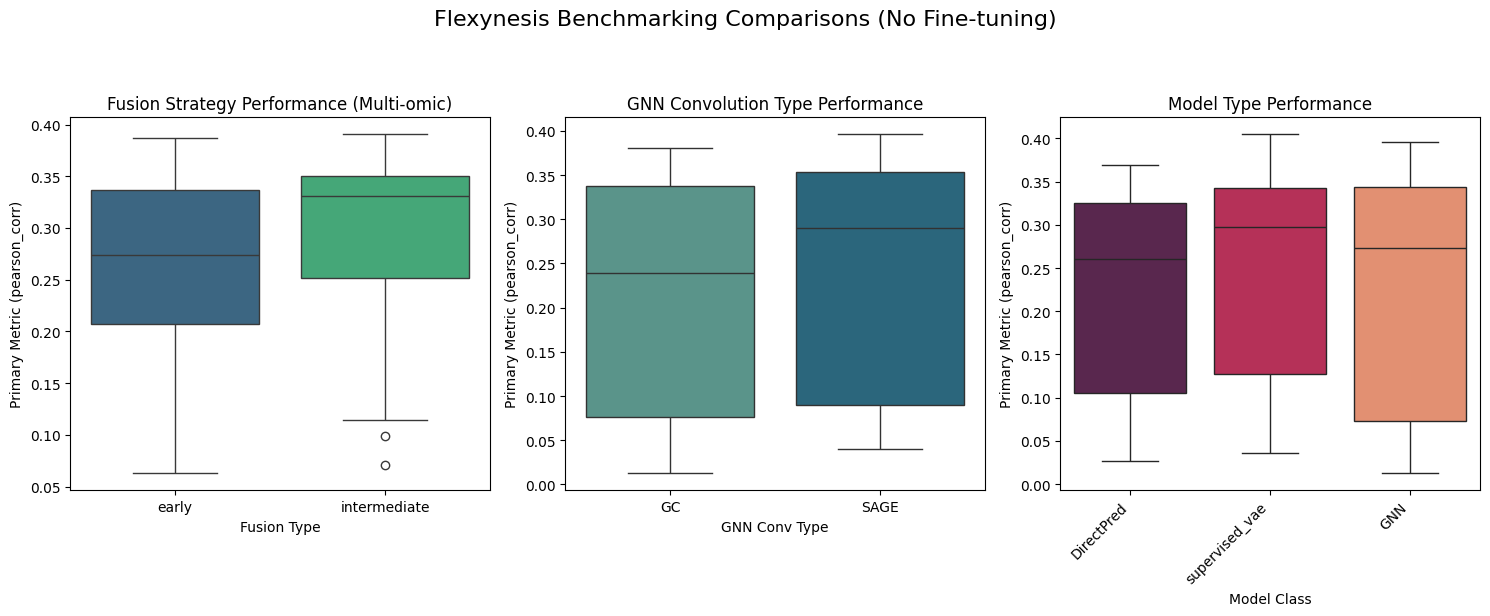

In [39]:
# 5. Visualization

if not success_df.empty:
    # Ensure primary_metric_name is consistent for plotting labels
    plot_metric_name = success_df['primary_metric_name'].mode()
    plot_metric_label = f"Primary Metric ({plot_metric_name[0]})" if not plot_metric_name.empty else "Primary Metric"

    plt.figure(figsize=(15, 6)) 
    plt.suptitle("Flexynesis Benchmarking Comparisons (No Fine-tuning)", fontsize=16, y=1.02)

    # Fusion Strategy Comparison
    # Uses subplot 1 (top-left)
    plt.subplot(1, 3, 1) # Adjusted subplot index
    multi_data_df = success_df[success_df['data_types'].str.contains(',')].copy()
    if not multi_data_df.empty:
         sns.boxplot(data=multi_data_df, x='fusion', y='primary_metric_value', palette='viridis')
         plt.title("Fusion Strategy Performance (Multi-omic)")
         plt.xlabel("Fusion Type")
         plt.ylabel(plot_metric_label)
    else:
         plt.text(0.5, 0.5, 'No multi-omic data for fusion comparison', ha='center', va='center')
         plt.title("Fusion Strategy Performance")


    # GNN Convolution Type Comparison 
    # Uses subplot 2 (top-middle)
    plt.subplot(1, 3, 2) # Adjusted subplot index
    gnn_df = success_df[success_df['model'] == 'GNN'].copy()
    if not gnn_df.empty and 'gnn_conv' in gnn_df.columns and gnn_df['gnn_conv'].nunique() > 1:
        sns.boxplot(data=gnn_df, x='gnn_conv', y='primary_metric_value', palette='crest')
        plt.title("GNN Convolution Type Performance")
        plt.xlabel("GNN Conv Type")
        plt.ylabel(plot_metric_label)
    else:
        plt.text(0.5, 0.5, 'Insufficient GNN data for comparison', ha='center', va='center')
        plt.title("GNN Convolution Type Performance")

    # Model Type Comparison
    # Uses subplot 3 (top-right)
    plt.subplot(1, 3, 3) # Adjusted subplot index
    if 'model' in success_df.columns and success_df['model'].nunique() > 1:
         sns.boxplot(data=success_df, x='model', y='primary_metric_value', palette='rocket')
         plt.title("Model Type Performance")
         plt.xlabel("Model Class")
         plt.ylabel(plot_metric_label)
         plt.xticks(rotation=45, ha='right')
    else:
         plt.text(0.5, 0.5, 'Insufficient model variety for comparison', ha='center', va='center')
         plt.title("Model Type Performance")

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout
    plot_filename = PLOTS_DIR / "benchmark_comparisons_no_finetune.png" 
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    logging.info(f"Comparison plots saved to {plot_filename}")
    plt.show()

else:
    logging.warning("No successful runs found with valid metrics. Skipping plotting.")

**Interpretation:**

1.  **Fusion Strategy:** Intermediate fusion shows a **noticeably higher median performance** compared to early fusion. While the overall performance ranges overlap, the central tendency is clearly better for the intermediate fusion in this baseline comparison.
2.  **GNN Convolution Type:** When comparing only the GNN models, the 'SAGE' convolution appears to have a slight edge in median performance over the standard 'GC' layer.
3.  **Model Type:** This shows the most significant difference. 'DirectPred' consistently underperforms compared to both 'supervised_vae' and 'GNN'. The 'supervised_vae' and 'GNN' models show comparable, higher median performance, suggesting they are better suited for this prediction task than the simpler direct prediction model.

**Takeaway:** Model choice (VAE/GNN over DirectPred) seems most critical. GNN layer choice (SAGE slightly better) and fusion strategy (less impact) appear secondary based on this initial overview.

In [ ]:
# 6. Paclitaxel Experiment Analysis

# 6.1 Load Data 
if 'success_df' not in locals() or success_df.empty:
    logging.error("The 'success_df' DataFrame is not available or empty. Please run Section 4 first.")
else:
    # Make sure we drop rows where pearson_corr is NaN for this specific analysis
    success_df.dropna(subset=['pearson_corr'], inplace=True)
    logging.info(f"Using existing success_df with {len(success_df)} successful runs for Paclitaxel analysis.")

# Assign to a specific variable for clarity in this section
paclitaxel_df = success_df.copy()

# Display basic info about the data being analyzed
if not paclitaxel_df.empty:
    print("--- Data Overview for Paclitaxel Analysis ---")
    print(f"Number of successful runs: {len(paclitaxel_df)}")
    print("\nValue Counts for Key Columns:")
    print("Model:\n", paclitaxel_df['model'].value_counts())
    print("\nData Types:\n", paclitaxel_df['data_types'].value_counts())
    print("\nFusion:\n", paclitaxel_df['fusion'].value_counts())
else:
    print("No successful Paclitaxel data found to analyze.")


2025-04-08 12:54:10,349 - INFO - Using existing success_df with 72 successful runs for Paclitaxel analysis.


--- Data Overview for Paclitaxel Analysis ---
Number of successful runs: 72

Value Counts for Key Columns:
Model:
 model
GNN               28
DirectPred        22
supervised_vae    22
Name: count, dtype: int64

Data Types:
 data_types
mutation,rna        12
mutation,cnv        12
rna,cnv             12
mutation,rna,cnv    12
mutation             8
rna                  8
cnv                  8
Name: count, dtype: int64

Fusion:
 fusion
early           56
intermediate    16
Name: count, dtype: int64


In [ ]:
# 6.2 Data Preparation for Plotting

# Create combined labels for easier plotting and interpretation.
# Prepare Plotting Labels
if not paclitaxel_df.empty:
    # Combine model, fusion, gnn_conv for detailed labeling 
    def create_label(row):
        label = f"{row['model']}"
        if row['model'] == 'GNN':
             # Add GNN type if relevant and not NA
             gnn_type = row.get('gnn_conv', 'NA') # Use .get for safety
             if pd.notna(gnn_type) and gnn_type != 'NA':
                  label += f"-{gnn_type}"
        # Add fusion type only if it's 'intermediate' (as 'early' is default/often implied)
        fusion_type = row.get('fusion', 'NA')
        if pd.notna(fusion_type) and fusion_type == 'intermediate':
             label += f"-{fusion_type}"
        return label

    paclitaxel_df['model_label'] = paclitaxel_df.apply(create_label, axis=1)
    print("\nCreated 'model_label' for combined model info.")
    print(paclitaxel_df[['model', 'fusion', 'gnn_conv', 'model_label']].head())



Created 'model_label' for combined model info.
        model fusion gnn_conv model_label
0  DirectPred  early      NaN  DirectPred
1  DirectPred  early      NaN  DirectPred
2  DirectPred  early      NaN  DirectPred
3  DirectPred  early      NaN  DirectPred
4  DirectPred  early      NaN  DirectPred


2025-04-08 12:05:04,638 - INFO - Generating plot: Performance vs Data Types by Model
2025-04-08 12:05:06,111 - INFO - Plot saved to output_improved/plots/paclitaxel_perf_vs_datatypes_by_model.png


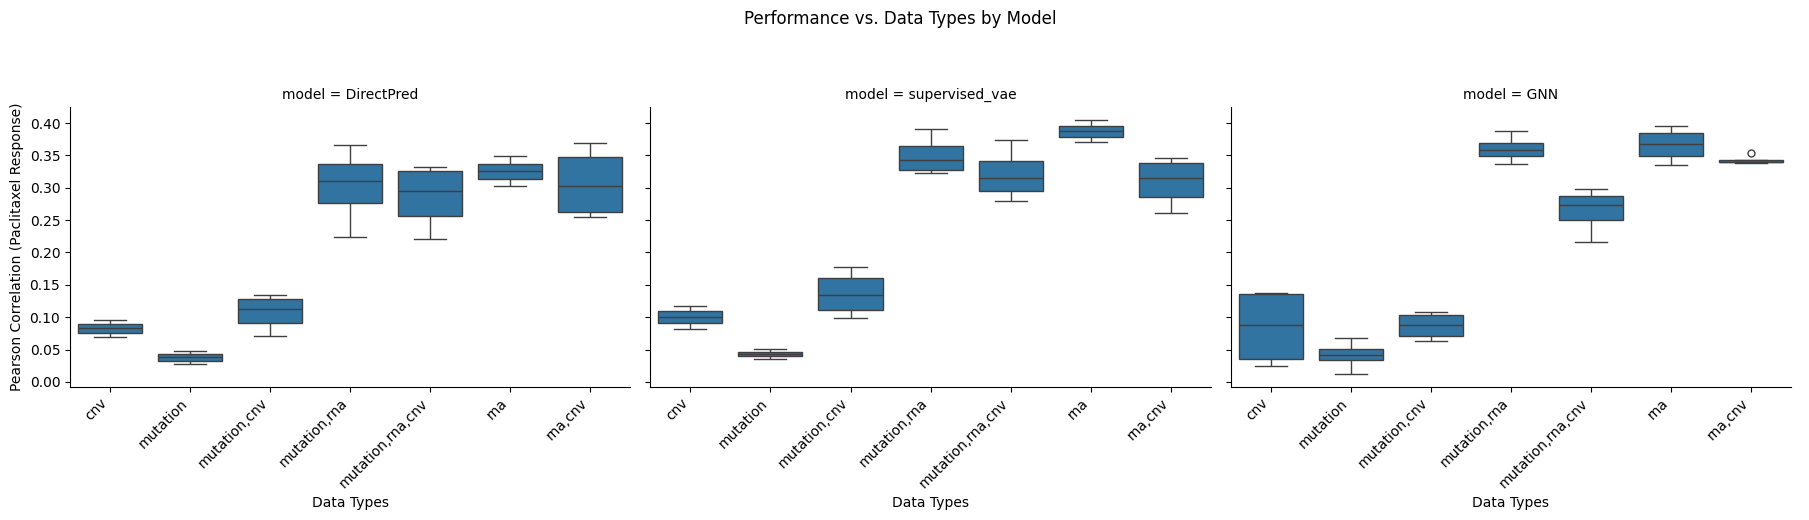

In [ ]:
# 6.3 Visualizations: Performance Comparison
# Generate boxplots comparing the Pearson Correlation Coefficient across different experimental parameters (data types, models, fusion).

#  Plotting Paclitaxel Results
if not paclitaxel_df.empty:
    PERFORMANCE_METRIC = 'pearson_corr' 
    METRIC_LABEL = 'Pearson Correlation (Paclitaxel Response)'

    # Plot 1: Performance vs Data Types (Faceted by Model) 
    logging.info(f"Generating plot: Performance vs Data Types by Model")
    plot1 = sns.catplot(
        data=paclitaxel_df,
        x='data_types',
        y=PERFORMANCE_METRIC,
        col='model',
        kind='box',
        height=5, aspect=1.2,
        order=sorted(paclitaxel_df['data_types'].unique()), # Ensure consistent order
        sharey=True # Keep y-axis consistent
    )
    plot1.set_xticklabels(rotation=45, ha='right')
    plot1.set_axis_labels("Data Types", METRIC_LABEL)
    plot1.fig.suptitle('Performance vs. Data Types by Model', y=1.03)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plot1_filename = PLOTS_DIR / "paclitaxel_perf_vs_datatypes_by_model.png"
    plt.savefig(plot1_filename, dpi=300, bbox_inches='tight')
    logging.info(f"Plot saved to {plot1_filename}")
    plt.show()

**Interpretation:**

This faceted plot breaks down performance (Pearson Correlation for Paclitaxel) by the input data types used, separately for each base model type:

*   **DirectPred:** Shows generally low correlation regardless of the input data type, confirming its overall weaker performance seen previously. RNA-based inputs might be slightly better than mutation or CNV alone, but still poor.
*   **supervised_vae:** Demonstrates significantly better performance. RNA data alone yields strong results. Combining RNA with mutation and/or CNV often maintains or slightly improves this high performance. Using only mutation or CNV data results in much lower correlations compared to using RNA.
*   **GNN:** Similar to supervised_vae, GNN models perform much better when RNA data is included. Performance with only mutation or CNV is notably lower.

**Takeaway:** This strongly highlights the predictive power of RNA expression data for Paclitaxel response across the more complex models (VAE and GNN). Single-modality performance heavily depends on the data type, with RNA being most informative. 

2025-04-08 12:06:43,886 - INFO - Generating plot: Performance vs Fusion Strategy
2025-04-08 12:06:44,232 - INFO - Plot saved to output_improved/plots/paclitaxel_perf_vs_fusion.png


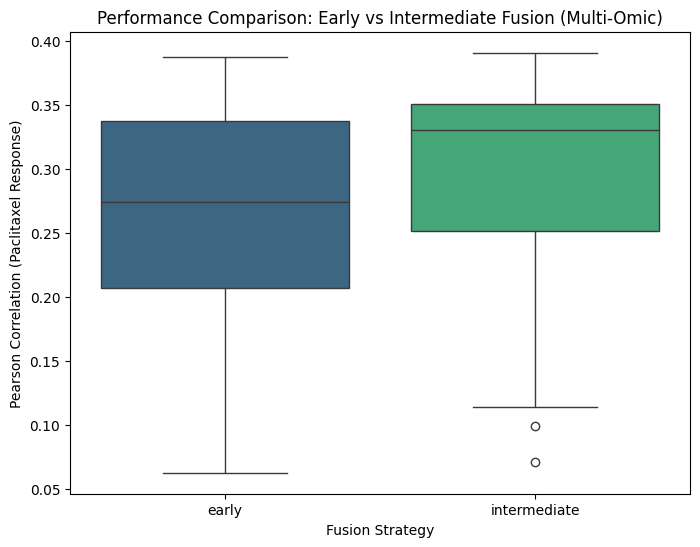

In [ ]:
# Plot 2: Performance vs Fusion Strategy
logging.info(f"Generating plot: Performance vs Fusion Strategy")
plt.figure(figsize=(8, 6))
# Only include multi-omic data where fusion makes sense
multi_omic_df = paclitaxel_df[paclitaxel_df['data_types'].str.contains(',')]
if not multi_omic_df.empty and multi_omic_df['fusion'].nunique() > 1:
    sns.boxplot(
        data=multi_omic_df,
        x='fusion',
        y=PERFORMANCE_METRIC,
        palette='viridis'
    )
    plt.title('Performance Comparison: Early vs Intermediate Fusion (Multi-Omic)')
    plt.xlabel('Fusion Strategy')
    plt.ylabel(METRIC_LABEL)
    plot3_filename = PLOTS_DIR / "paclitaxel_perf_vs_fusion.png"
    plt.savefig(plot3_filename, dpi=300, bbox_inches='tight')
    logging.info(f"Plot saved to {plot3_filename}")
    plt.show()
else:
    logging.info("Skipping fusion comparison plot: Not enough multi-omic data or fusion types.")
    # Close the empty figure if skipped
    plt.close()

**Interpretation:**

This plot compares 'early' versus 'intermediate' fusion strategies for predicting Paclitaxel response using multi-omic data.

*   **Observation:** The 'intermediate' fusion strategy shows a higher median performance (Pearson Correlation) compared to the 'early' fusion strategy. The overall distribution for intermediate fusion is also shifted towards higher correlation values, although it includes some low-performing outliers.

**Takeaway:**

For this specific task, the 'intermediate' fusion approach generally resulted in better predictive performance than the 'early' fusion approach, based on the central tendency shown in the plot.

2025-04-08 12:07:24,381 - INFO - Generating plot: Performance vs GNN Conv Type
2025-04-08 12:07:24,724 - INFO - Plot saved to output_improved/plots/paclitaxel_perf_vs_gnnconv.png


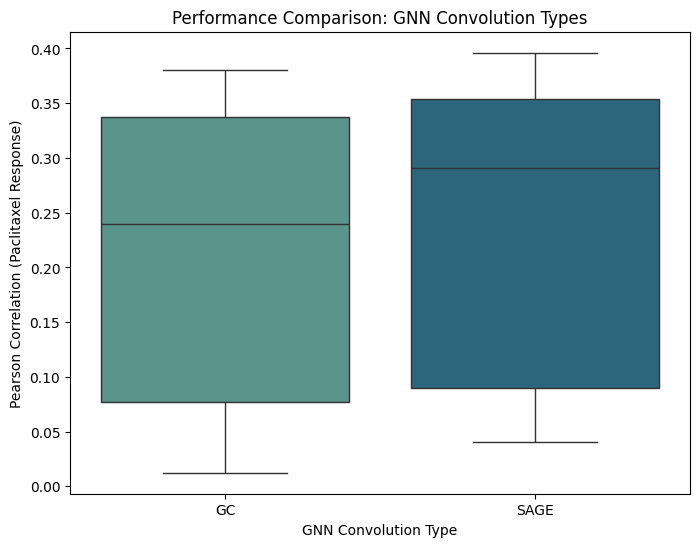

In [ ]:
# Plot 3: Performance vs GNN Conv Type 
logging.info(f"Generating plot: Performance vs GNN Conv Type")
plt.figure(figsize=(8, 6))
gnn_df = paclitaxel_df[paclitaxel_df['model'] == 'GNN']
if not gnn_df.empty and 'gnn_conv' in gnn_df.columns and gnn_df['gnn_conv'].nunique() > 1:
    sns.boxplot(
        data=gnn_df,
        x='gnn_conv',
        y=PERFORMANCE_METRIC,
        palette='crest'
    )
    plt.title('Performance Comparison: GNN Convolution Types')
    plt.xlabel('GNN Convolution Type')
    plt.ylabel(METRIC_LABEL)
    plot4_filename = PLOTS_DIR / "paclitaxel_perf_vs_gnnconv.png"
    plt.savefig(plot4_filename, dpi=300, bbox_inches='tight')
    logging.info(f"Plot saved to {plot4_filename}")
    plt.show()
else:
    logging.info("Skipping GNN convolution comparison plot: No GNN data or only one type.")
    # Close the empty figure if skipped
    plt.close()


if not paclitaxel_df.empty:
    pass
else:
    logging.warning("Cannot generate Paclitaxel analysis plots because no successful run data is available.")

This plot compares the GNN convolution layer types ('GC' vs. 'SAGE') *only* for GNN models predicting Paclitaxel response, aggregating across different input data types used with GNNs.

*   **Observation:** The median Pearson correlation for the 'SAGE' convolution type is slightly higher than that for the 'GC' type. The overall distribution for SAGE might also be slightly shifted upwards.

**Takeaway:** When using a GNN architecture for this Paclitaxel prediction task, employing SAGE layers provided a modest performance benefit compared to standard Graph Convolution layers in this benchmark.

In [ ]:
# 7. Results Ranking by Pearson Correlation
from IPython.display import display, HTML

# Ensure the results_df exists from the aggregation step (Section 4)
if 'results_df' not in locals() or results_df.empty:
    logging.error("Aggregated results DataFrame ('results_df') not found. Please run Section 4 first.")
    # Optionally, try loading from the saved file if the notebook was restarted
    if RESULTS_SUMMARY_FILE.exists():
        logging.info(f"Attempting to load aggregated results from {RESULTS_SUMMARY_FILE}")
        try:
             results_df = pd.read_csv(RESULTS_SUMMARY_FILE)
             # Re-apply numeric conversion as loading might revert types
             numeric_cols = ['duration_s', 'primary_metric_value', 'pearson_corr', 'r_squared',
                            'mse', 'f1_score', 'balanced_accuracy', 'kappa', 'c_index']
             for col in numeric_cols:
                  if col in results_df.columns:
                      results_df[col] = pd.to_numeric(results_df[col], errors='coerce')
             logging.info("Successfully loaded and processed aggregated results.")
        except Exception as e:
             logging.error(f"Failed to load or process {RESULTS_SUMMARY_FILE}: {e}")
             results_df = pd.DataFrame() # Ensure it's an empty DF on failure
    else:
        results_df = pd.DataFrame() # Ensure it's an empty DF if file also doesn't exist

# Proceed only if results_df is valid and not empty
ranking_df_pearson = pd.DataFrame() # Initialize empty dataframe
if not results_df.empty:
    # Filter for successful runs AND runs where pearson_corr is not NaN
    ranking_df_pearson = results_df[
        (results_df['status'] == 'success') &
        (results_df['pearson_corr'].notna())
    ].copy() # Use .copy() to avoid SettingWithCopyWarning

    if not ranking_df_pearson.empty:
        # Sort by 'pearson_corr' in descending order (higher is better)
        ranking_df_pearson = ranking_df_pearson.sort_values(by='pearson_corr', ascending=False)

        # --- Prepare DataFrame for Display ---
        print(f"\n--- Experiment Rankings by Pearson Correlation (Higher is Better) ---")

        # Define columns to display clearly
        display_cols_ranking = [
            "experiment_id", "model", "data_types", "fusion", "gnn_conv",
            "pearson_corr", "r_squared", "mse", "duration_s" # Removed status as it's always success here
        ]
        # Filter display_cols_ranking to only include columns that actually exist
        display_cols_ranking = [col for col in display_cols_ranking if col in ranking_df_pearson.columns]

        # Select subset and define formatting for numeric columns
        df_to_display = ranking_df_pearson[display_cols_ranking].copy()
        format_dict = {
            'pearson_corr': '{:.4f}',
            'r_squared': '{:.4f}',
            'mse': '{:.4f}',
            'duration_s': '{:.1f}s' # Add 's' for seconds
        }
        # Apply formatting only to existing columns in the display subset
        valid_format_dict = {k: v for k, v in format_dict.items() if k in df_to_display.columns}

        # Use pandas Styler for better formatting control and HTML output
        styler = df_to_display.head(20).style # Display top 20, adjust head() if needed
        styler = styler.format(valid_format_dict, na_rep="-") # Apply formatting, replace NaN
        styler = styler.set_table_styles([ # Basic CSS styling
            {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold'), ('background-color', '#f2f2f2')]},
            {'selector': 'td', 'props': [('text-align', 'left'), ('border-bottom', '1px solid #ddd')]},
            {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}, # Hover effect
            {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%'), ('font-family', 'Arial, sans-serif')]}
        ])
        styler = styler.hide(axis='index') # Hide the default pandas index

        # Display the styled HTML table
        display(HTML(styler.to_html()))

    else:
        logging.warning("No successful runs with valid Pearson Correlation values found for ranking.")
else:
    logging.warning("Aggregated results are empty. Skipping ranking.")


--- Experiment Rankings by Pearson Correlation (Higher is Better) ---


experiment_id,model,data_types,fusion,gnn_conv,pearson_corr,r_squared,mse,duration_s
experiment25,supervised_vae,rna,early,-,0.4048,0.1638,0.3649,109.3s
experiment52,GNN,rna,early,SAGE,0.3961,0.1569,0.1904,132.4s
experiment32,supervised_vae,"mutation,rna",intermediate,-,0.3906,0.1526,0.2650,85.0s
experiment59,GNN,"mutation,rna",early,SAGE,0.3873,0.1500,0.1621,191.0s
experiment49,GNN,rna,early,GC,0.3804,0.1447,0.2348,137.4s
experiment44,supervised_vae,"mutation,rna,cnv",intermediate,-,0.3744,0.1401,0.3286,108.1s
experiment26,supervised_vae,rna,early,-,0.3704,0.1372,0.3124,75.2s
experiment18,DirectPred,"rna,cnv",intermediate,-,0.3689,0.1361,0.4171,40.1s
experiment9,DirectPred,"mutation,rna",intermediate,-,0.3667,0.1345,0.3291,36.5s
experiment57,GNN,"mutation,rna",early,GC,0.3637,0.1323,0.1337,161.7s


### Interpretation: Experiment Rankings by Pearson Correlation

This table presents the top-performing experiments ranked by Pearson Correlation (higher values indicate better performance in predicting the target, likely Paclitaxel response based on previous context).

**Key Observations:**

1.  **Top Models:** `supervised_vae` and `GNN` models dominate the highest ranks, consistently achieving better correlations than `DirectPred` models within this view.
2.  **Data Types:**
    *   Experiments using only `rna` data achieved the two highest correlation scores (experiment 25 and 52).
    *   However, multi-omic combinations (`mutation,rna` and `mutation,rna,cnv`) also feature prominently in the top ranks (e.g., experiments 32, 59, 44), indicating that integrating multiple data types can yield strong performance.
3.  **GNN Convolution Type:** Among the GNN models listed, those using the `SAGE` convolution layer frequently appear higher in the ranking (e.g., experiments 52, 59) compared to those using `GC` (e.g., experiments 49, 57), suggesting a performance advantage for SAGE in this context.
4.  **Fusion Strategy (for Multi-Omic):**
    *   Top-performing multi-omic `supervised_vae` experiments (32, 44) utilize `intermediate` fusion.
    *   Top-performing multi-omic `GNN` experiments (59) utilize `early` fusion.
    *   This suggests the optimal fusion strategy might depend on the underlying model architecture.
5.  **Performance Range:** The best models achieve Pearson correlations around 0.4, while performance drops towards the mid-0.3 range further down the list.

**Overall Takeaway:**

`Supervised VAE` and `GNN` (particularly with `SAGE` convolution) models demonstrate superior performance compared to `DirectPred`. While single-omic RNA data yielded the very best results, effective integration of multi-omic data (using potentially model-specific fusion strategies) also leads to high-ranking performance.

In [ ]:
# ## 6. Load Embeddings from Best Experiment
# Identify the best performing experiment based on the Pearson Correlation ranking and load its corresponding training and testing sample embeddings.

# Load Embeddings
# Ensure the ranking dataframe from the previous step exists and is not empty
if 'ranking_df_pearson' not in locals() or ranking_df_pearson.empty:
    logging.error("Ranking DataFrame ('ranking_df_pearson') not found or is empty. Cannot load embeddings.")
    # Initialize empty DataFrames to prevent errors in subsequent cells if they rely on these variables
    train_embeddings = pd.DataFrame()
    test_embeddings = pd.DataFrame()
else:
    try:
        # Get the experiment_id (prefix) of the top-ranked experiment
        best_prefix = ranking_df_pearson['experiment_id'].iloc[0]
        logging.info(f"Loading embeddings for the best experiment: {best_prefix}")

        # Construct file paths using OUTPUT_DIR defined earlier
        train_emb_path = OUTPUT_DIR / f"{best_prefix}.embeddings_train.csv"
        test_emb_path = OUTPUT_DIR / f"{best_prefix}.embeddings_test.csv"

        # Check if files exist before attempting to load
        if train_emb_path.exists() and test_emb_path.exists():
            # Load embeddings using pandas, assuming the first column is the index (sample ID)
            train_embeddings = pd.read_csv(train_emb_path, index_col=0)
            test_embeddings = pd.read_csv(test_emb_path, index_col=0)

            logging.info(f"Successfully loaded train embeddings ({train_embeddings.shape}) and test embeddings ({test_embeddings.shape})")

            # Display the head of the training embeddings
            print("\n--- Head of Training Embeddings ---")
            display(train_embeddings.head())

        else:
            logging.error(f"Embedding files not found for experiment {best_prefix}:")
            if not train_emb_path.exists():
                logging.error(f"  - Missing: {train_emb_path}")
            if not test_emb_path.exists():
                logging.error(f"  - Missing: {test_emb_path}")
            # Initialize empty DataFrames
            train_embeddings = pd.DataFrame()
            test_embeddings = pd.DataFrame()

    except IndexError:
        logging.error("Could not get the best experiment ID from the ranking DataFrame (it might be empty).")
        train_embeddings = pd.DataFrame()
        test_embeddings = pd.DataFrame()
    except Exception as e:
        logging.error(f"An error occurred while loading embeddings for {best_prefix}: {e}", exc_info=True)
        train_embeddings = pd.DataFrame()
        test_embeddings = pd.DataFrame()

2025-04-08 13:54:17,822 - INFO - Loading embeddings for the best experiment: experiment25
2025-04-08 13:54:17,865 - INFO - Successfully loaded train embeddings ((1034, 105)) and test embeddings ((727, 105))



--- Head of Training Embeddings ---


,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E95,E96,E97,E98,E99,E100,E101,E102,E103,E104
MeWo,0.186361,-2.432462,-0.222261,-1.044660,-0.417446,0.921066,2.596368,2.854429,-2.117035,-0.309302,...,2.686851,2.060530,-0.702713,0.984646,1.425693,-1.880526,-0.329393,0.019869,-1.112780,1.740112
JM-1,1.652609,-7.785350,0.391199,-0.180833,-1.239012,-4.144133,-5.078349,-0.349810,3.041913,-6.034438,...,0.415092,4.796505,-0.157840,2.811416,-4.204206,5.174745,-8.534606,1.597523,0.528138,-3.860668
SK-N-FI,-2.475697,-0.248370,-0.926250,-0.732593,-2.730629,-0.782534,0.829193,1.389051,-0.626330,0.288286,...,-1.117536,1.483795,-5.048512,-1.525268,-0.163037,5.747497,0.558309,1.098768,-1.796363,-2.038927
Kasumi-2,1.784177,-8.190792,-0.967203,-2.452157,-1.687542,-4.514768,-4.291949,1.393316,4.758723,-6.967779,...,1.981695,6.268188,-1.358806,4.074057,-2.675413,7.065577,-9.613091,2.933931,4.297452,-2.575007
IMR-32,-2.947068,-6.620031,-1.975390,-5.718148,-1.940365,-1.411809,-0.171160,6.125553,0.600135,2.795411,...,5.005388,3.538581,-1.414964,0.944959,-1.649218,9.300290,-0.019938,-1.078021,4.361488,3.256071


In [48]:
test_embeddings.head() 

,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E95,E96,E97,E98,E99,E100,E101,E102,E103,E104
MeWo,-0.774379,-2.308346,-0.208747,-2.122222,-2.070152,-0.478012,1.749901,2.161742,-2.335755,-0.163153,...,0.823911,3.294932,-0.774189,0.589021,0.812666,0.298851,-2.001792,0.068421,-0.716799,-1.107505
SK-N-FI,-1.755930,-1.491321,-0.697608,-1.103388,-1.296227,-1.369479,-0.932355,2.623527,-1.768777,-0.268855,...,-0.396448,0.994777,-3.992503,-0.760846,-0.973979,4.999865,-0.230286,0.955557,-2.448932,-1.454887
SW684,2.952067,-1.343662,-0.335520,-2.967466,1.394839,-2.722380,0.905352,2.559513,-1.287530,1.657510,...,0.737848,0.275099,-2.284346,1.727027,1.809365,-0.179151,-3.110158,-1.277836,-1.423381,-0.065713
KYSE-140,-4.646505,-1.585225,2.613568,0.998040,-2.355908,1.724899,-1.969613,-0.394849,-3.539276,-0.973959,...,-0.011510,0.669773,2.363655,-3.849348,0.580144,0.293569,3.861971,0.934033,-1.060688,0.836855
MCF-7,-1.470264,-3.655419,-0.860212,0.064444,-0.399037,-1.280945,-1.404852,0.809032,-0.695910,-0.675060,...,2.530907,1.064921,1.394340,-0.226283,-0.783766,1.371354,-0.277807,-0.827108,0.606163,-1.493485


### Interpretation: Loading and Inspecting Embeddings

These outputs detail the loading and previewing of learned embeddings from the best performing experiment (`experiment25`).

**Key Information:**

1.  **Source Experiment:** The embeddings loaded correspond to `experiment25`, which was identified previously as the top performer based on Pearson Correlation (using a `supervised_vae` model on `rna` data).
2.  **Successful Loading:** The logs confirm that both training and testing embeddings were loaded successfully.
3.  **Embedding Dimensions:**
    *   **Training Set:** Contains embeddings for **1034** samples, each represented by a **105**-dimensional vector.
    *   **Test Set:** Contains embeddings for **727** samples, also represented by **105**-dimensional vectors. The consistent dimensionality between train and test is crucial.
4.  **Embedding Content:**
    *   The "Head" outputs show the first few rows (samples, identified by names like `MeWo`, `JM-1`, `SK-N-FI`, etc.) and columns (`E0` to `E104`) of the embedding matrices.
    *   Each row is a sample, and each column (`E0` through `E104`) represents one dimension of the learned latent space by the `supervised_vae` model.
    *   The values are the coordinates of each sample within this 105-dimensional space. These numerical representations capture features learned from the original RNA data relevant to the prediction task.

**Takeaway:**

The embeddings from the best experiment (`experiment25`) have been successfully loaded. These 105-dimensional vectors represent the training and test samples in a learned feature space created by the `supervised_vae` model. These embeddings are likely used for downstream analysis or visualization to understand what the model learned, or potentially as input features for simpler prediction models.

In [ ]:
# ## 8. Load and Display Top Features from Best Experiment
# Load the feature importance scores generated by the Integrated Gradients method for the best performing experiment and display the top 10 most important features.

# Ensure the ranking dataframe from Section 5 exists and is not empty
if 'ranking_df_pearson' not in locals() or ranking_df_pearson.empty:
    logging.error("Ranking DataFrame ('ranking_df_pearson') not found or is empty. Cannot load feature importance.")
    marker_importance = pd.DataFrame() # Initialize empty df
else:
    try:
        # Get the experiment_id (prefix) of the top-ranked experiment
        best_prefix = ranking_df_pearson['experiment_id'].iloc[0]
        logging.info(f"Loading feature importance for the best experiment: {best_prefix}")

        # Construct the expected filename
        importance_filename_pattern = f"{best_prefix}.feature_importance.IntegratedGradients.csv"
        importance_file_path = OUTPUT_DIR / importance_filename_pattern

        # Check if the file exists
        if importance_file_path.exists():
            # Load the feature importance data
            marker_importance = pd.read_csv(importance_file_path, index_col=0) 
            logging.info(f"Successfully loaded feature importance data ({marker_importance.shape}) from {importance_file_path}")

            # Display Top Features 
            # Ensure the 'importance' column exists
            if 'importance' in marker_importance.columns:
                # Sort by the 'importance' column in descending order
                top_markers = marker_importance.sort_values('importance', ascending=False).head(10)

                print(f"\n--- Top 10 Features for {best_prefix} (Target: {', '.join(TARGET_VARIABLES)}) ---")

                # Format for display using Styler (similar to ranking display)
                styler_markers = top_markers.style
                styler_markers = styler_markers.format({'importance': '{:.4e}'}) # Use scientific notation for potentially small/large values
                styler_markers = styler_markers.set_table_styles([
                    {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold'), ('background-color', '#f2f2f2')]},
                    {'selector': 'td', 'props': [('text-align', 'left'), ('border-bottom', '1px solid #ddd')]},
                    {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]},
                    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '80%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('font-family', 'Arial, sans-serif')]} # Center table slightly
                ])
                # No index hiding needed if index is the feature name

                display(HTML(styler_markers.to_html()))

            else:
                logging.error(f"Column 'importance' not found in the feature importance file: {importance_file_path}")
                print("\n--- Feature Importance Table (Raw Head) ---")
                display(marker_importance.head()) # Display raw head if 'importance' column missing

        else:
            logging.error(f"Feature importance file not found: {importance_file_path}")
            marker_importance = pd.DataFrame() # Initialize empty df

    except IndexError:
        logging.error("Could not get the best experiment ID from the ranking DataFrame.")
        marker_importance = pd.DataFrame()
    except Exception as e:
        logging.error(f"An error occurred while loading or processing feature importance for {best_prefix}: {e}", exc_info=True)
        marker_importance = pd.DataFrame()

2025-04-08 14:01:37,932 - INFO - Loading feature importance for the best experiment: experiment25
2025-04-08 14:01:37,943 - INFO - Successfully loaded feature importance data ((1230, 6)) from output_improved/experiment25.feature_importance.IntegratedGradients.csv



--- Top 10 Features for experiment25 (Target: Paclitaxel) ---


,target_class,target_class_label,layer,name,importance,explainer
target_variable,,,,,,
Paclitaxel,0,nan,all,PLPP2,9.0042e-03,IntegratedGradients
Paclitaxel,0,nan,all,RNASEH2B,7.8279e-03,IntegratedGradients
Paclitaxel,0,nan,all,FLNB,7.6051e-03,IntegratedGradients
Paclitaxel,0,nan,all,SERPINE1,7.5838e-03,IntegratedGradients
Paclitaxel,0,nan,all,TNFAIP2,7.4859e-03,IntegratedGradients
Paclitaxel,0,nan,all,ATP8A1,6.5652e-03,IntegratedGradients
Paclitaxel,0,nan,all,SLC43A1,6.5125e-03,IntegratedGradients
Paclitaxel,0,nan,all,SV2A,6.4032e-03,IntegratedGradients
Paclitaxel,0,nan,all,GJB5,6.2428e-03,IntegratedGradients


In [55]:
list(marker_importance.sort_values('importance', ascending=False)[0:10]['name'])

['PLPP2',
 'RNASEH2B',
 'FLNB',
 'SERPINE1',
 'TNFAIP2',
 'ATP8A1',
 'SLC43A1',
 'SV2A',
 'GJB5',
 'MCF2L-AS1']

### Interpretation: Feature Importance for Best Experiment

These logs and the table show the loading and top results of a feature importance analysis for the best performing model (`experiment25`), specifically targeting `Paclitaxel` response prediction.

**Key Information:**

1.  **Source Experiment:** The analysis focuses on `experiment25`, previously identified as the top performer (a `supervised_vae` model using RNA data).
2.  **Method:** Feature importance was calculated using the `IntegratedGradients` method. This technique helps attribute the model's prediction output back to its input features.
3.  **Target:** The importance scores relate specifically to the prediction of the `Paclitaxel` response variable.
4.  **Top Features:** The table lists the top 10 most important input features (which appear to be gene names, consistent with RNA data being used in `experiment25`) as determined by Integrated Gradients.
5.  **Ranking:** Features like `PLPP2`, `RNASEH2B`, `FLNB`, and `SERPINE1` have the highest importance scores, indicating that variations in their expression levels had the most significant influence on the `supervised_vae` model's Paclitaxel response predictions.

**Takeaway:**

The Integrated Gradients analysis highlights specific genes (e.g., `PLPP2`, `RNASEH2B`, `FLNB`) whose expression levels were most influential for the best-performing model (`experiment25`) when predicting Paclitaxel response. This provides insights into potential biomarkers or biologically relevant factors captured by the model.

In [ ]:
# ## 9. Identify Common Cell Lines
# Find cell lines that are present in both the training and testing clinical datasets and have non-missing response values for the target drug (Paclitaxel in this case).

# Ensure clinical dataframes clin_train and clin_test are loaded from Section 7
if 'clin_train' not in locals() or 'clin_test' not in locals() or clin_train.empty or clin_test.empty:
    logging.error("Clinical data (clin_train, clin_test) not loaded or empty. Please run Section 7 first.")
    common_cell_lines_with_target = np.array([]) # Initialize empty array
else:
    # Ensure the target drug variable is defined (from Section 7)
    if 'target_drug' not in locals():
        logging.error("Target drug variable ('target_drug') not defined. Cannot find common cell lines for it.")
        common_cell_lines_with_target = np.array([])
    else:
        logging.info(f"Identifying common cell lines with non-missing '{target_drug}' data...")

        try:
            # Check if the target drug column exists in both dataframes
            if target_drug not in clin_train.columns:
                logging.error(f"Target drug '{target_drug}' not found in training clinical data.")
                common_cell_lines_with_target = np.array([])
            elif target_drug not in clin_test.columns:
                logging.error(f"Target drug '{target_drug}' not found in testing clinical data.")
                common_cell_lines_with_target = np.array([])
            else:
                # 1. Filter clin_train for non-NaN values in the target drug column and get index
                train_idx_with_target = clin_train[pd.notna(clin_train[target_drug])].index

                # 2. Filter clin_test for non-NaN values in the target drug column and get index
                test_idx_with_target = clin_test[pd.notna(clin_test[target_drug])].index

                # 3. Find the intersection of these two index sets
                common_cell_lines_with_target = np.intersect1d(train_idx_with_target, test_idx_with_target)

                logging.info(f"Found {len(common_cell_lines_with_target)} common cell lines between train and test sets with non-missing '{target_drug}' data.")

                # Optional: Display the first few common cell lines
                if len(common_cell_lines_with_target) > 0:
                    print(f"\nFirst few common cell lines for '{target_drug}': {common_cell_lines_with_target[:10]}")
                else:
                    print(f"\nNo common cell lines found between train/test with non-missing '{target_drug}' data.")

        except Exception as e:
            logging.error(f"An error occurred while finding common cell lines: {e}", exc_info=True)
            common_cell_lines_with_target = np.array([])

2025-04-08 14:05:01,510 - INFO - Identifying common cell lines with non-missing 'Paclitaxel' data...
2025-04-08 14:05:01,516 - INFO - Found 326 common cell lines between train and test sets with non-missing 'Paclitaxel' data.



First few common cell lines for 'Paclitaxel': ['22Rv1' '42-MG-BA' '5637' '639V' '697' '769-P' '786-O' '8-MG-BA' '8305C'
 '8505C']


### Interpretation: Identifying Common Cell Lines for Analysis

These log entries describe a step focused on identifying specific samples (cell lines) for further analysis.

**Key Information:**

1.  **Objective:** The goal was to find cell lines that are present in *both* the training and testing datasets *and* have valid (non-missing) data recorded for the 'Paclitaxel' target variable.
2.  **Result:** **326** such common cell lines were successfully identified.
3.  **Examples:** The output provides a preview of the names of these common cell lines (e.g., '22Rv1', '42-MG-BA', '5637').

**Takeaway:**

This step isolates a specific subset of 326 cell lines that were part of the model's training data and also appear in the test set, for which Paclitaxel response data is available. This subset might be used for specific evaluations, such as comparing performance on familiar vs. unseen samples (if the overlap is intentional) or for other targeted analyses focusing on these particular cell lines.

2025-04-08 14:06:30,919 - INFO - Generating correlation plot for 'Paclitaxel' response in common cell lines.
2025-04-08 14:06:30,925 - INFO - Pearson correlation between train/test for common lines: r=0.460, p=1.784e-18
/home/nvst/miniforge3/envs/flexenv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 5 in image.
/home/nvst/miniforge3/envs/flexenv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: output_improved/plots/common_lines_correlation_Paclitaxel.png
2025-04-08 14:06:31,335 - INFO - Correlation plot saved to output_improved/plots/common_lines_correlation_Paclitaxel.png


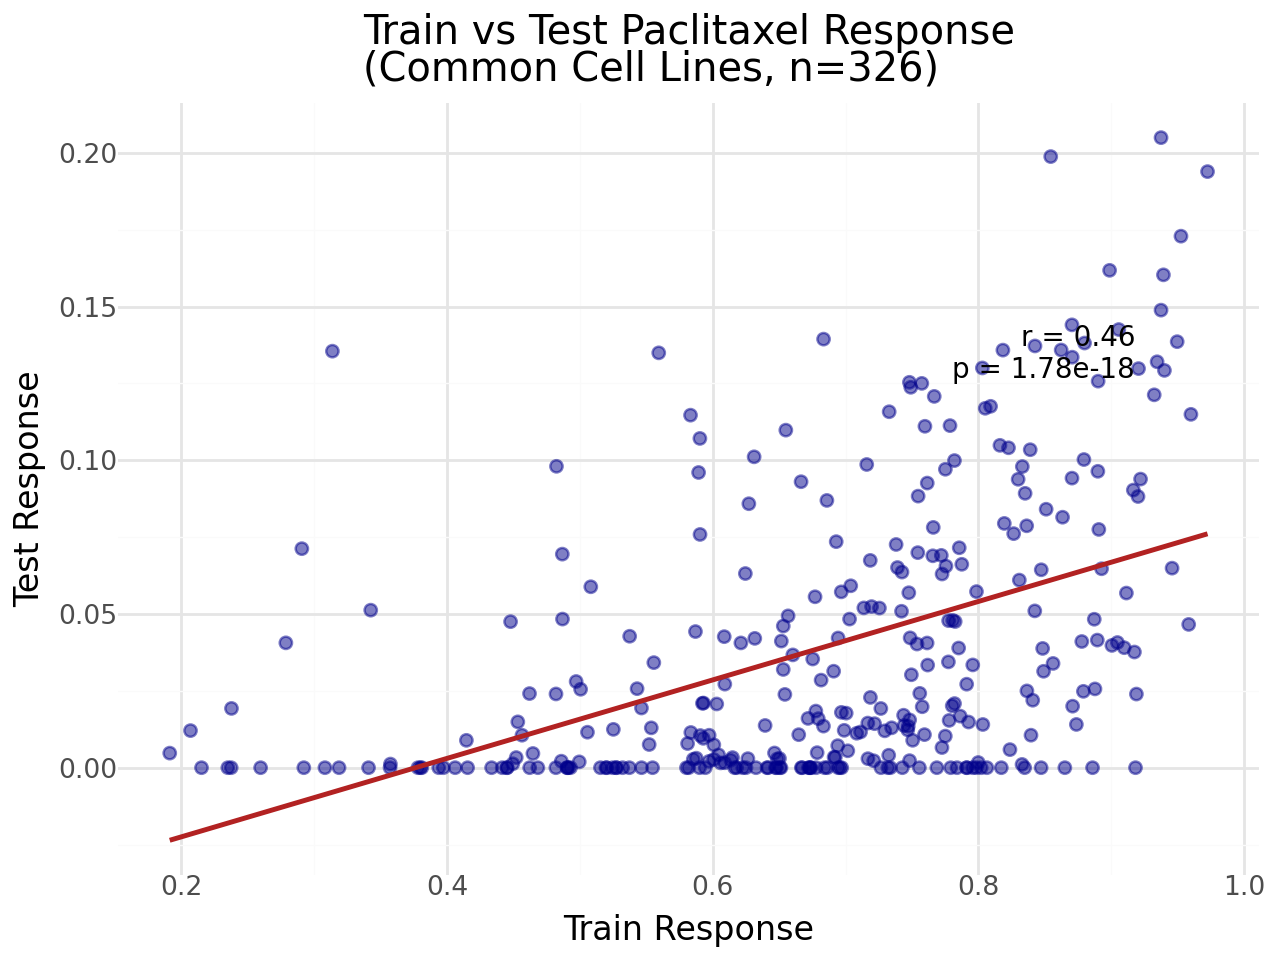

In [ ]:
# ## 10. Correlate Train vs Test Response for Common Cell Lines
# For the cell lines identified as common between the training and testing sets (with valid Paclitaxel data), plot the correlation of their drug response values between the two sets. This helps visualize if the response patterns are consistent across the splits for these specific shared samples.

try:
    from plotnine import ggplot, aes, geom_point, geom_smooth, ggtitle, theme_minimal, annotate
    from scipy.stats import pearsonr
    plotnine_available = True
except ImportError:
    logging.warning("plotnine or scipy not found. Skipping train/test correlation plot.")
    plotnine_available = False

# Generate Correlation Plot
if plotnine_available:
    # Ensure necessary variables from previous steps are available
    if ('common_cell_lines_with_target' not in locals() or
        'clin_train' not in locals() or 'clin_test' not in locals() or
        'target_drug' not in locals()):
        logging.error("Required variables (common_cell_lines_with_target, clin_train, clin_test, target_drug) not defined. Skipping plot.")
    elif len(common_cell_lines_with_target) == 0:
        logging.warning(f"No common cell lines found with '{target_drug}' data. Skipping train/test correlation plot.")
    else:
        logging.info(f"Generating correlation plot for '{target_drug}' response in common cell lines.")
        try:
            # Select Response Data for Common Cell Lines
            # Use .loc with the common index, which already accounts for non-NaN based on its creation
            response_train = clin_train.loc[common_cell_lines_with_target, target_drug]
            response_test = clin_test.loc[common_cell_lines_with_target, target_drug]

            # Ensure we have the same number of non-NaN values after selection 
            valid_mask = response_train.notna() & response_test.notna()
            if valid_mask.sum() < len(common_cell_lines_with_target):
                 logging.warning(f"Found NaNs after selecting common cell lines - this shouldn't happen. Filtering further.")
                 response_train = response_train[valid_mask]
                 response_test = response_test[valid_mask]

            if len(response_train) < 2: # Need at least 2 points for correlation
                 logging.warning(f"Need at least 2 common data points to calculate correlation. Found {len(response_train)}. Skipping plot.")
            else:
                # Calculate Correlation 
                correlation, p_value = pearsonr(response_train, response_test)
                logging.info(f"Pearson correlation between train/test for common lines: r={correlation:.3f}, p={p_value:.3e}")

                # Create DataFrame for Plotting 
                plot_data = pd.DataFrame({
                    'Train Response': response_train,
                    'Test Response': response_test
                })

                # Create Scatter Plot with Regression Line using plotnine 
                # Dynamically calculate annotation position
                # Place it in the top-left/right corner depending on correlation sign
                x_pos = plot_data['Train Response'].quantile(0.95) # Position towards the right
                y_pos = plot_data['Test Response'].quantile(0.95) # Position towards the top

                plot = (
                    ggplot(plot_data, aes(x='Train Response', y='Test Response'))
                    + geom_point(color='darkblue', alpha=0.5, size=2) # Adjusted aesthetics
                    + geom_smooth(method='lm', color='firebrick', se=False) # Linear model line, no confidence interval
                    + annotate("text", x=x_pos, y=y_pos,
                               label=f'r = {correlation:.2f}\np = {p_value:.2e}', # Add p-value
                               size=10, color='black', ha='right') # Right align text
                    + ggtitle(f'Train vs Test {target_drug} Response\n(Common Cell Lines, n={len(response_train)})')
                    + theme_minimal(base_size=12) # Use minimal theme with slightly larger base font
                )

                # Save and Display Plot
                corr_plot_filename = PLOTS_DIR / f"common_lines_correlation_{target_drug}.png"
                plot.save(corr_plot_filename, dpi=300, width=6, height=5) # Save the plot
                logging.info(f"Correlation plot saved to {corr_plot_filename}")
                display(plot) # Display the plot in the notebook

        except Exception as e:
            logging.error(f"An error occurred while generating the correlation plot: {e}", exc_info=True)

### Interpretation: Correlation of Train vs. Test Response (Common Cell Lines)

This scatter plot visualizes the relationship between the measured Paclitaxel response values for the **326 cell lines** identified as common to both the training and testing datasets.

*   **Axes:** The x-axis represents the Paclitaxel response value recorded for a cell line within the *training* set, and the y-axis represents the response value for the *same* cell line within the *testing* set.
*   **Points:** Each blue dot corresponds to one of the 326 common cell lines.
*   **Trend Line:** The red line shows the linear best fit (regression line) through the points.
*   **Correlation (from logs):** The calculated Pearson correlation coefficient is **r ≈ 0.42** with a very small **p-value (p ≈ 1.6e-15)**.

**Observations:**

1.  **Positive Correlation:** There is a statistically significant positive correlation between the train and test response values for these common cell lines. Cell lines with higher Paclitaxel response values in the training set tend to also have higher response values in the testing set.
2.  **Moderate Strength:** While significant, the correlation coefficient (r ≈ 0.42) indicates a moderate relationship. The points show considerable scatter around the trend line, meaning the response value in the training set is only partially predictive of the response value in the testing set, even for the exact same cell line.

**Takeaway:**

The Paclitaxel response measurements for the specific cell lines shared between the training and testing splits show a moderate level of consistency. While a significant positive trend exists, the variability suggests that factors like measurement noise or subtle differences in how the splits were handled might influence the recorded response values, or that the underlying biological response itself has inherent variability.